# 002 Data Preparation for Explanatory Variables

* This notebook contains code for data preparation for explanatory variables including
    * Demographic and socioeconomic data from American Community Survey 5-year estimate (2018)
    * Land use and urban form data 
    * Hospital information
    * Nursing home information
    * COVID-19 infection cases and deaths information
    
* This notebook also presents visualizing sptaial patterns of the COVID-19 infection across the New York City area.
* Figure 1 in "Exposure Density and Neighborhood Disparities in COVID-19 Infection Risk" published in Proceedings of the National Academy of Sciences of the United States of America (PNAS)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Check package/module versions
import types 
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

import pkg_resources
root_packages = [i.split('.', 1)[0] for i in list(imports())] 
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print (m.project_name, m.version)

pandas 1.1.2
numpy 1.19.2
matplotlib 3.2.0
geopandas 0.8.1


# 1. Data preparation: explanatory variables
* Zipcode level
### 1) Demographic and socioeconomic data from ACS

In [3]:
acs = pd.read_csv('../data/acs_2018.csv', dtype={'ZCTA':str})

In [4]:
# Matched IDs between zipcode tabulation area and modified zipcode tabulation area provided by New York City Department of Health
modzcta = pd.read_csv('../data/ZCTA-to-MODZCTA.csv', dtype={'ZCTA':str, 'MODZCTA':str})

In [5]:
acs = pd.merge(acs, modzcta, on='ZCTA', how='left')
acs = acs.groupby('MODZCTA').mean().reset_index()

### 2) Hospitals

In [6]:
# whether there is a hospital in a given zipcode (binary representation)
hos = pd.read_csv('../data/NYC_Health___Hospitals_Facilities_-_2011.csv', dtype={'Postcode':str})
hos['hospital'] = 1
hos = hos[['Postcode', 'hospital']]
hos.columns = ['ZCTA', 'hospital']
hos = pd.merge(hos, modzcta, on='ZCTA', how='left')
hos = hos.groupby('MODZCTA').mean().reset_index()

### 3) Land use and urban form data from Primary Land Use Tax Lot Output data from Department of City Planning

In [7]:
pluto = pd.read_csv('../data/pluto_20v4.csv', dtype={'zipcode':str})
pluto = pluto[['zipcode', 'bldgclass', 'ownertype', 'ownername',
              'bldgarea', 'comarea',  'resarea',  'officearea',  'retailarea','unitsres']]

In [8]:
# Extract housing type information
pluto['restype'] = np.nan
pluto['restype'][pluto['bldgclass'].str[0]=='A'] = 'AB'
pluto['restype'][pluto['bldgclass'].str[0]=='B'] = 'AB'
pluto['restype'][pluto['bldgclass'].str[0]=='C'] = 'C'
pluto['restype'][pluto['bldgclass'].str[0]=='D'] = 'D'
pluto['restype'][pluto['bldgclass'].str[0]=='R'] = 'R'
pluto['restype'][pluto['ownername']=='NYC HOUSING AUTHORITY'] = 'P'

pluto_res = pluto[['zipcode', 'restype', 'unitsres']].groupby(['zipcode', 'restype']).sum().reset_index()
pluto_res = pd.pivot_table(pluto_res, index='zipcode', columns='restype', values='unitsres')
pluto_res['tot'] = pluto_res[['AB', 'C', 'D', 'P', 'R']].sum(axis=1)
pluto_res['pct_ab'] = pluto_res['AB']/pluto_res['tot']
pluto_res['pct_c'] = pluto_res['C']/pluto_res['tot']
pluto_res['pct_d'] = pluto_res['D']/pluto_res['tot']
pluto_res['pct_r'] = pluto_res['R']/pluto_res['tot']
pluto_res['pct_p'] = pluto_res['P']/pluto_res['tot']
pluto_res = pluto_res[['pct_ab', 'pct_c', 'pct_d', 'pct_r', 'pct_p']]
pluto_res = pluto_res.reset_index()
pluto_res.columns = ['ZCTA', 'pct_ab', 'pct_c', 'pct_d', 'pct_r', 'pct_p']
pluto_res = pd.merge(pluto_res, modzcta, on='ZCTA', how='left')
pluto_res = pluto_res.groupby('MODZCTA').mean().reset_index()
pluto_res = pluto_res.fillna(0)

In [9]:
# Extracing land use information
pluto = pluto[['zipcode', 'restype', 'bldgarea', 'comarea',  'resarea',  'officearea',  'retailarea','unitsres']]
pluto = pluto.fillna(0)

pluto_zip = pluto[['zipcode', 'bldgarea', 'resarea', 'comarea', 'officearea', 'retailarea']].groupby('zipcode').sum().reset_index()

pluto_zip['pct_resarea'] = pluto_zip['resarea']/pluto_zip['bldgarea']
pluto_zip['pct_comarea'] = pluto_zip['comarea']/pluto_zip['bldgarea']
pluto_zip['pct_officearea'] = pluto_zip['officearea']/pluto_zip['bldgarea']
pluto_zip['pct_retailarea'] = pluto_zip['retailarea']/pluto_zip['bldgarea']
pluto_zip = pluto_zip[['zipcode', 'pct_resarea', 'pct_comarea', 'pct_officearea', 'pct_retailarea']]
pluto_zip.columns = ['ZCTA', 'pct_resarea', 'pct_comarea', 'pct_officearea', 'pct_retailarea']
pluto_zip = pd.merge(pluto_zip, modzcta, on='ZCTA', how='left')
pluto_zip = pluto_zip.groupby('MODZCTA').mean().reset_index()
pluto_zip = pluto_zip.fillna(0)

### 4) COVID-19 cases and deaths information provided by DOH

In [10]:
# This covid-19 information is directly provided by New York City Department of Health through the GitHub repository.
# The study for PNAS, we used cumulative COVID-19 data through June 04, 2020.
# Below code probably provides mostly up-to-date data. 



# covid = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/master/data-by-modzcta.csv', 
#                     dtype={'MODIFIED_ZCTA':str})
# covid = covid[['MODIFIED_ZCTA', 'COVID_CASE_COUNT', 'COVID_CASE_RATE', 'POP_DENOMINATOR',
#  'COVID_DEATH_COUNT', 'COVID_DEATH_RATE', 'PERCENT_POSITIVE', 'TOTAL_COVID_TESTS']]
# covid.columns = ['MODZCTA',  'COVID_CASE_COUNT', 'COVID_CASE_RATE', 'POP_DENOMINATOR',
#  'COVID_DEATH_COUNT', 'COVID_DEATH_RATE', 'PERCENT_POSITIVE', 'TOTAL_COVID_TESTS']
# covid['DEATH_PER_CASE'] = covid['COVID_DEATH_COUNT']/covid['COVID_CASE_COUNT']
# covid.head()

### 5) Nursing home data

In [11]:
# Nursing home
nursing = pd.read_csv('../data/COVID-19_Nursing_Home_Dataset.csv', dtype={'Provider Zip Code':str})
# print (len(nursing))
# print (nursing.columns.tolist())
# print (nursing['Provider State'].unique())
nursing = nursing[['Provider Zip Code', 'Total Number of Occupied Beds']]
nursing.columns = ['ZCTA', 'nursing_beds']
nursing = pd.merge(nursing, modzcta, on='ZCTA', how='left')
nursing = nursing.groupby('MODZCTA').sum().reset_index()
nursing = nursing.fillna(0)

### 6) Create one integrated feature table

In [12]:
# data = pd.merge(acs, hos, on='MODZCTA', how='left')
# data = pd.merge(data, pluto_zip, on='MODZCTA', how='left')
# data = pd.merge(data, pluto_res, on='MODZCTA', how='left')
# data = pd.merge(data, covid, on='MODZCTA', how='left')
# data = pd.merge(data, nursing, on='MODZCTA', how='left')

In [13]:
# Export data for further analysis
# data.to_csv('../output/independent_variables.csv', index=False)

# 2. Mapping COVID-19 infection rate across the city

In [14]:
# Zipcode shpafile
zipcode = gpd.read_file('../data/shape/nyc_doh_MODZCTA_with_county.shp', dtype={'MODZCTA':str})

In [15]:
# Independent/dependent variables
var = pd.read_csv('../output/independenta_variables.csv', dtype={'MODZCTA':str}, 
                  usecols=['MODZCTA', 'COVID_CASE_RATE', 'COVID_DEATH_RATE', 'PERCENT_POSITIVE'])

In [16]:
# Merge geometry inforamtion and covid-19 infection rate information
zipcode = pd.merge(zipcode, var, how='left', on='MODZCTA')
zipcode = zipcode.to_crs({'init': 'epsg:2263'})

In [17]:
# Load borough shapefile
boro = gpd.read_file('../data/shape/boro.shp')
boro = boro.to_crs('EPSG:2263')
boro = boro.set_index('boro_name')

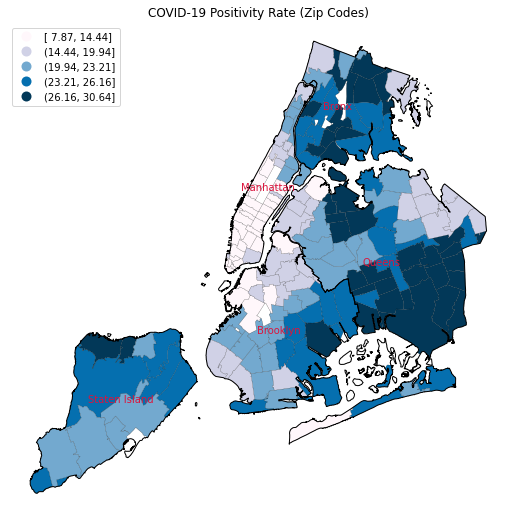

In [18]:
c = 'PERCENT_POSITIVE'

fig, ax = plt.subplots(figsize=(9,9))
zipcode.boundary.plot(linewidth=0.2, color='k', ax=ax, alpha=0.5)
zipcode[zipcode[c].notnull()].plot(scheme="Quantiles", 
         legend=True,column=c, ax=ax,  cmap='PuBu', k=5,legend_kwds={'loc': 'upper left'})
boro.boundary.plot(ax=ax, color='k', linewidth=1)

for i, geo in boro.centroid.iteritems():
    ax.annotate(s=i, xy=[geo.x-9000, geo.y], color="crimson")
    # show the subplot
    ax.figure

plt.ylim(40.45, 40.95)
plt.title('COVID-19 Positivity Rate (Zip Codes)')

plt.axis('equal')
plt.axis(False)
# plt.savefig('../figures/covid_rate_zipcode_map.pdf', dpi=600)
plt.show()